In [1]:
import trenchripper as tr

import anndata

import numpy as np
import pandas as pd
import scanpy as sc
import scipy.cluster.hierarchy as sch

import matplotlib.pyplot as plt

import goatools
import goatools.base
from goatools.base import download_go_basic_obo
from goatools.obo_parser import GODag
from goatools.anno.gaf_reader import GafReader
plt.style.use('./deaton.mplstyle')

## Load Functions

In [2]:
def search_go(ns2assoc, obodag, inv_gene_to_id, go_term):
    namespace_abbv = {"biological_process":"BP","molecular_function":"MF","cellular_component":"CC"}
    
    print("Searching for " + str(obodag[go_term].name))
    namespace = namespace_abbv[obodag[go_term].namespace]
    child_goterms = list(obodag[go_term].get_all_children())
    gene_list = [inv_gene_to_id[key] for key,val in ns2assoc[namespace].items() if go_term in val]
    for child_goterm in child_goterms:    
        gene_list += [inv_gene_to_id[key] for key,val in ns2assoc[namespace].items() if child_goterm in val]
    gene_list = sorted(list(set(gene_list)))
    return gene_list

## Load Data

In [3]:
anndata_df = anndata.read_h5ad("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/lDE20_Imaging/Clustering/AnnData_nonRcompat.h5ad")
anndata_df.obs.index = anndata_df.obs.index.astype(int)

anndata_df = sc.tl.paga(anndata_df,"L3",copy=True)
paga_connectivities = anndata_df.uns['paga']['connectivities']
paga_connectivities_tree = anndata_df.uns['paga']['connectivities_tree']

anndata_df.obs["X Coord"] = anndata_df.obsm['X_umap'][:,0]
anndata_df.obs["Y Coord"] = anndata_df.obsm['X_umap'][:,1]

/home/de64/micromamba/envs/crispri/lib/python3.11/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


## Figure S9A

In [4]:
# Get ontologies
obo_fname = download_go_basic_obo()

# Get ecoli association file (ecocyc)
gaf_handle = goatools.base.http_get("http://current.geneontology.org/annotations/ecocyc.gaf.gz",fout="./ecocyc.gaf.gz")
gaf_fname = goatools.base.gunzip("./ecocyc.gaf.gz")

## Getting ontologies and other nonesense

obodag = GODag(obo_fname)
objanno = GafReader(gaf_fname)
ns2assoc = objanno.get_ns2assc()

gene_to_id = {assoc.DB_Symbol:assoc.DB_ID for assoc in objanno.associations}
inv_gene_to_id = {assoc.DB_ID:assoc.DB_Symbol for assoc in objanno.associations}
synonym_dict = {synonym:assoc.DB_ID for assoc in objanno.associations for synonym in assoc.DB_Synonym}
gene_to_id.update(synonym_dict)

  EXISTS: go-basic.obo
requests.get(http://current.geneontology.org/annotations/ecocyc.gaf.gz, stream=True)
  WROTE: ./ecocyc.gaf.gz

go-basic.obo: fmt(1.2) rel(2024-10-27) 44,017 Terms
HMS:0:00:01.195937  58,540 annotations READ: ./ecocyc.gaf 


In [5]:
ribosomal_proteins = sorted(anndata_df.obs[anndata_df.obs["Gene"].apply(lambda x: ("rps" in x)|("rpm" in x)|("rpl" in x))]["Gene"].unique())
tRNA_aminoacylation_genes = search_go(ns2assoc, obodag, inv_gene_to_id, "GO:0043039")

Searching for tRNA aminoacylation


<Figure size 2400x2400 with 0 Axes>

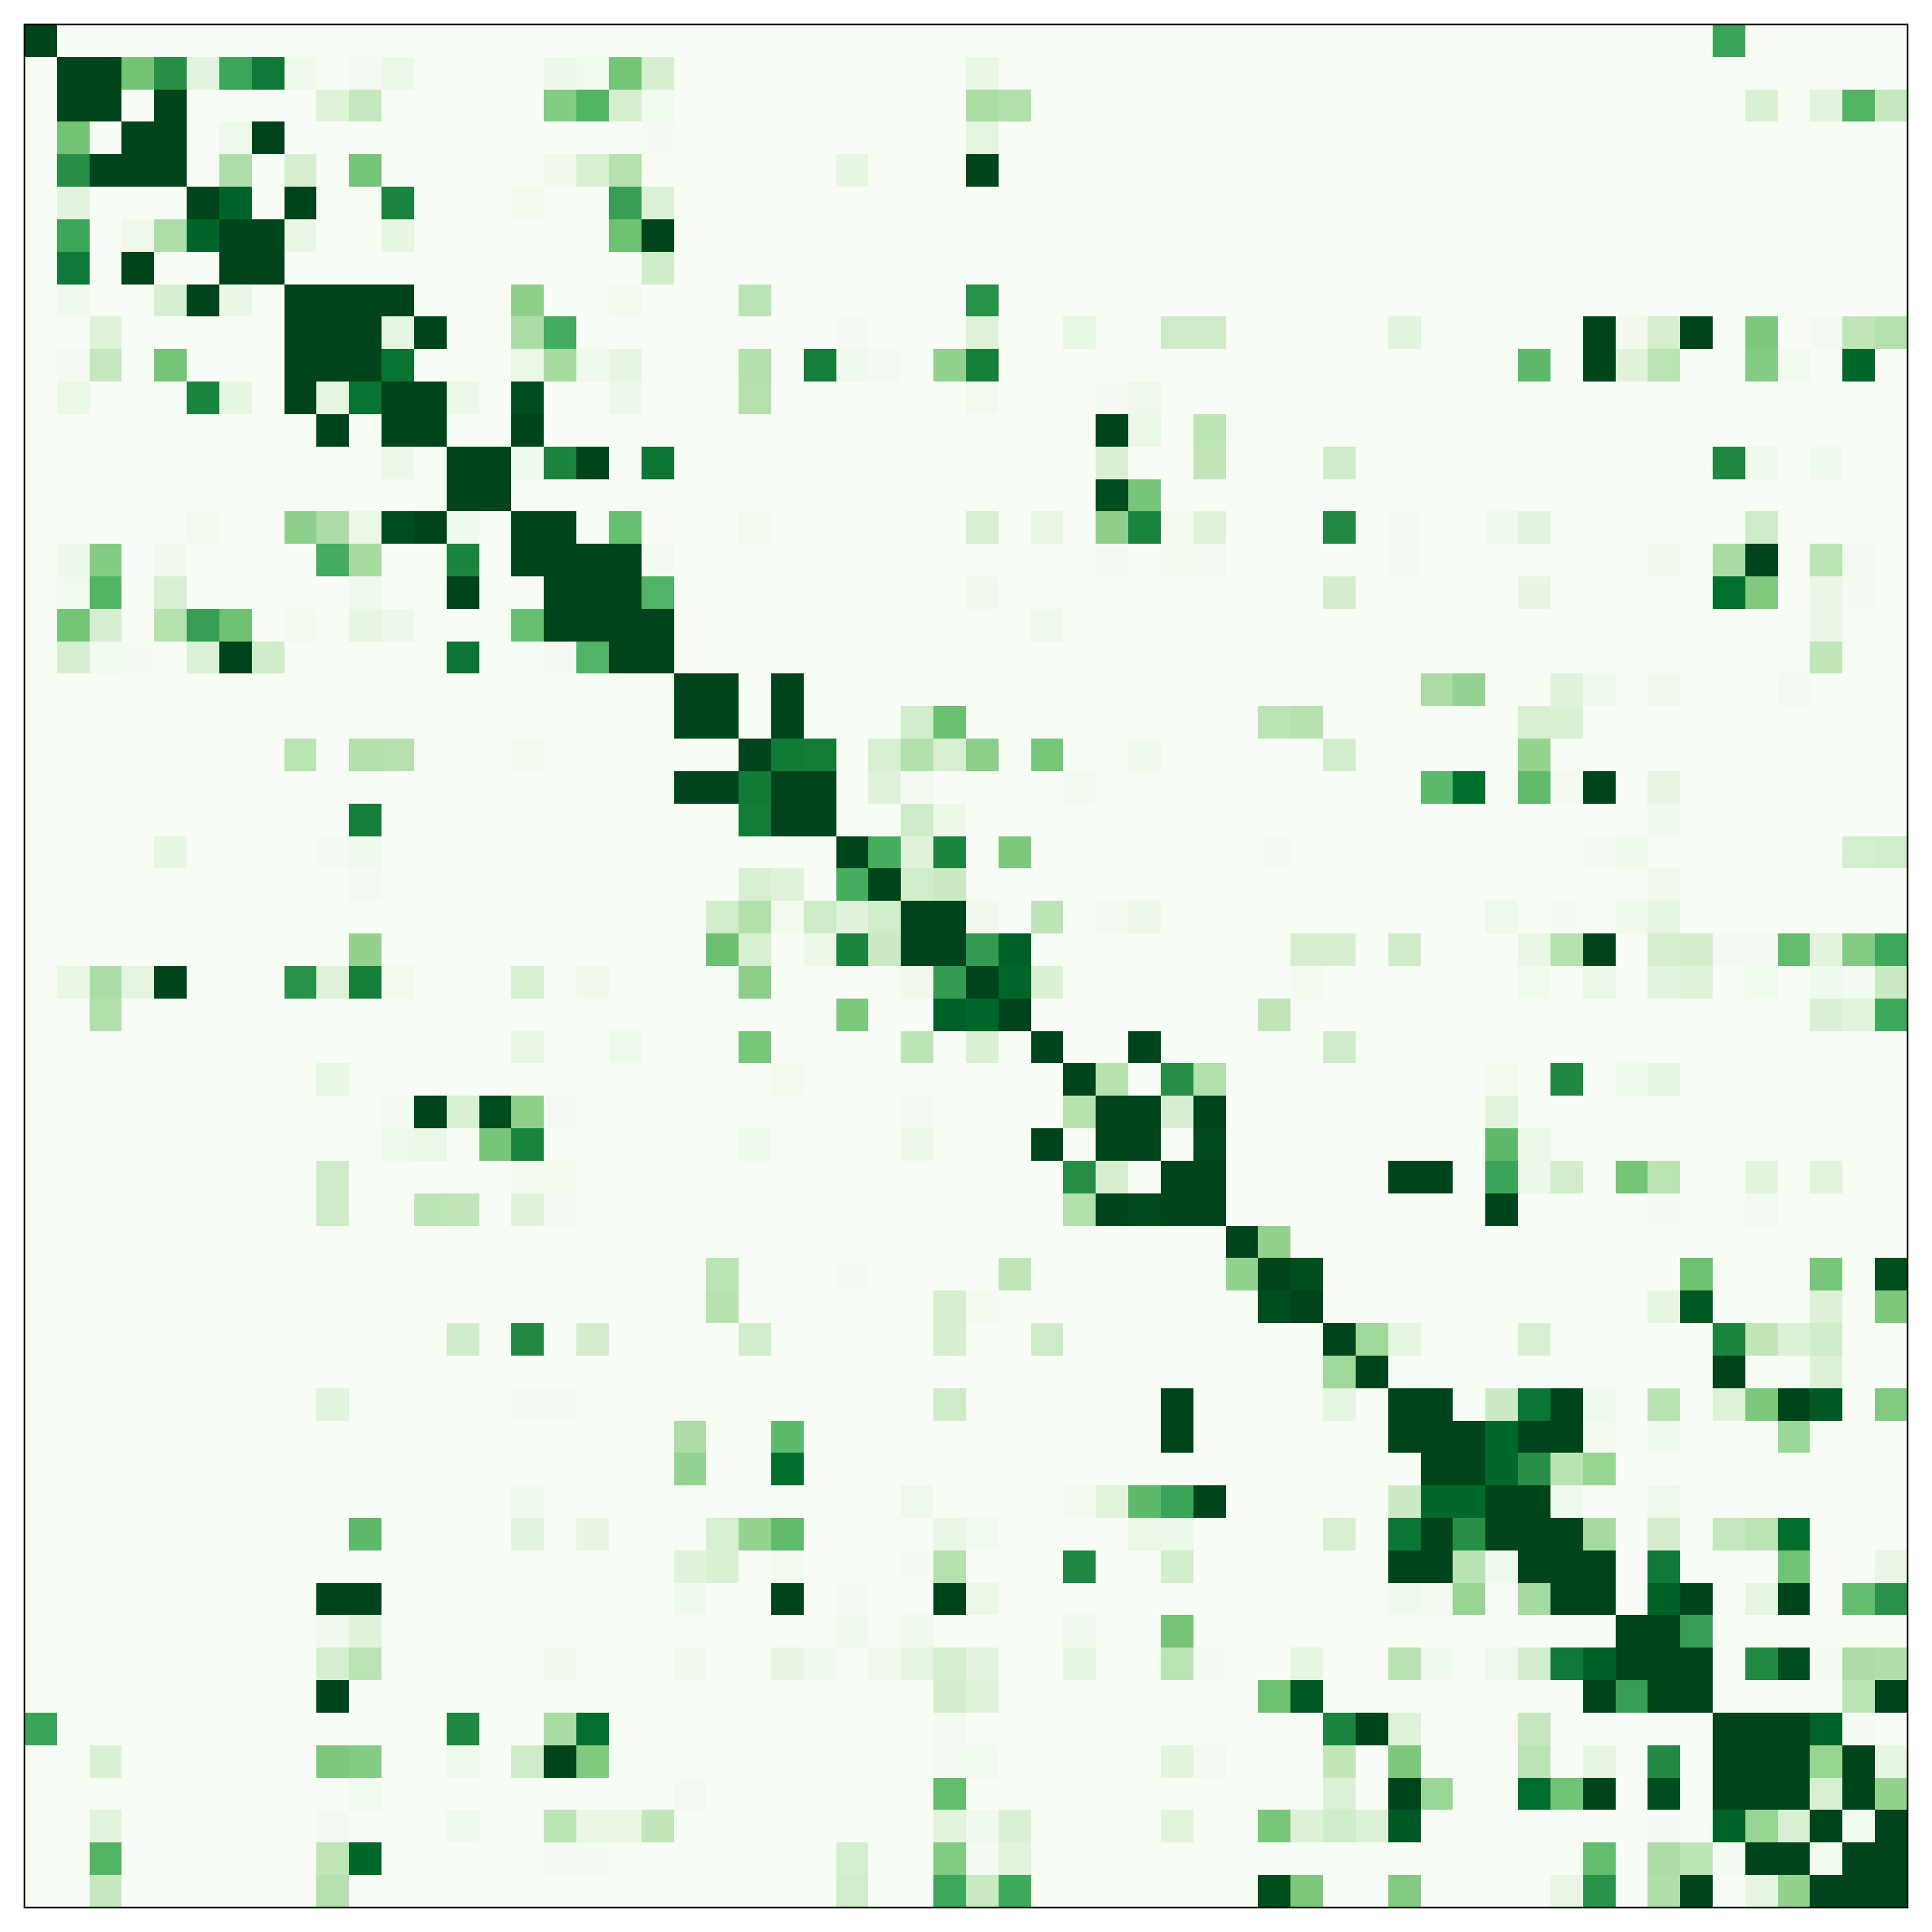

In [6]:
fig = plt.figure(figsize=(8,8))

##normal distance
distance_matrix = 1-paga_connectivities.toarray()
np.fill_diagonal(distance_matrix, 0)

labels = [f"Node {i}" for i in range(distance_matrix.shape[0])]

# Perform hierarchical clustering
# Generate the linkage matrix using the distance matrix (must be condensed for linkage)
condensed_matrix = sch.distance.squareform(distance_matrix)  # Convert to 1D condensed form
linkage_matrix = sch.linkage(condensed_matrix, method='average')

# Get the order of the rows/columns based on clustering
dendrogram = sch.dendrogram(linkage_matrix, labels=labels, no_plot=True)
ordered_indices = dendrogram['leaves']

# Reorder the matrix and labels
sorted_distance_matrix = distance_matrix[ordered_indices, :][:, ordered_indices]
sorted_labels = [labels[i] for i in ordered_indices]

# Plot the sorted matrix with labels
plt.figure(figsize=(8, 8))
imshow_out = plt.imshow(1-sorted_distance_matrix, cmap='Greens', interpolation='nearest')
# plt.colorbar(label='Connectivity (0-1)')
# plt.xticks(ticks=np.arange(len(sorted_labels)), labels=sorted_labels, rotation=90)
# plt.yticks(ticks=np.arange(len(sorted_labels)), labels=sorted_labels)
ax = plt.subplot(1,1,1)

ax.set_xticks([])  # Remove x-axis ticks
ax.set_yticks([])  # Remove y-axis ticks

# plt.title("Hierarchically Clustered Connectivity Matrix")
plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/S9/PAGA_Connectivity.png",dpi=500,transparent=True,bbox_inches="tight")

/tmp/ipykernel_36439/820437965.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.set_ticklabels(ticklabels=[0.,0.2,0.4,0.6,0.8,1.0],fontsize=16)


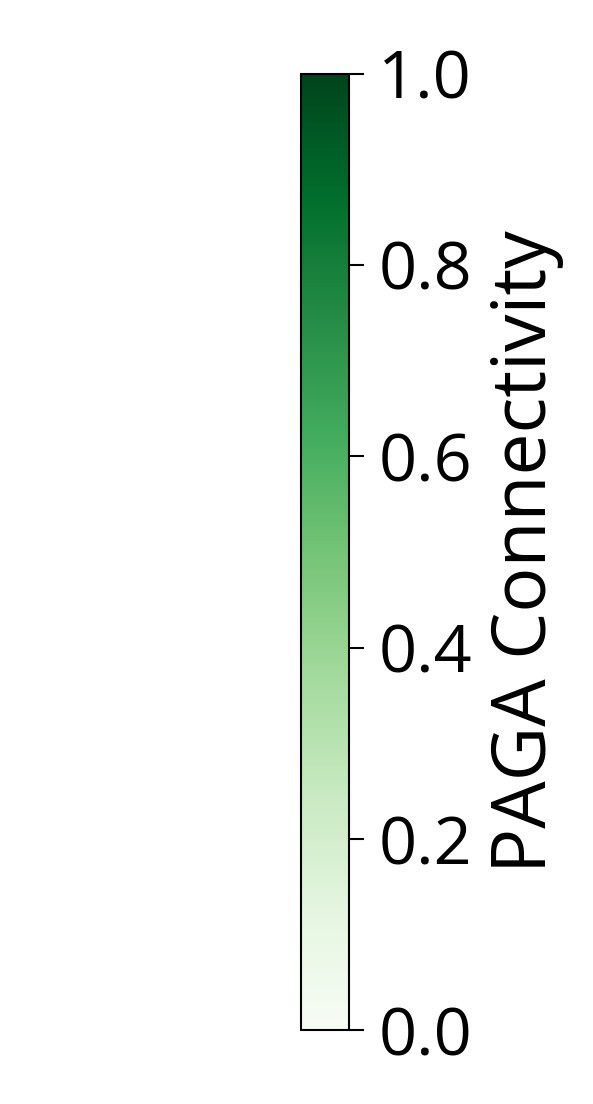

In [7]:
cbarfig, cbarax = plt.subplots(1,1,figsize=(2,4))
# Remove the axes' elements
cbarax.axis('off')
# Create a colorbar
cbar = cbarfig.colorbar(imshow_out, ax=cbarax)
# Optionally, set the label for the colorbar
cbar.set_label('PAGA Connectivity', fontsize=18)
cbar.set_ticklabels(ticklabels=[0.,0.2,0.4,0.6,0.8,1.0],fontsize=16)
plt.tight_layout()
plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/S9/Cbar.png",dpi=500,transparent=True,bbox_inches="tight")

In [8]:
perc_r_prot = anndata_df.obs.groupby("L3").apply(lambda x: np.sum(x["Gene"].isin(ribosomal_proteins))/len(x))
perc_trna = anndata_df.obs.groupby("L3").apply(lambda x: np.sum(x["Gene"].isin(tRNA_aminoacylation_genes))/len(x))

r_prot_perc_series = perc_r_prot.loc[[str(index) for index in ordered_indices]]
trna_perc_series = perc_trna.loc[[str(index) for index in ordered_indices]]

r_prot_perc_arr = r_prot_perc_series.values
trna_perc_arr = trna_perc_series.values

/tmp/ipykernel_36439/3954832291.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  perc_r_prot = anndata_df.obs.groupby("L3").apply(lambda x: np.sum(x["Gene"].isin(ribosomal_proteins))/len(x))
/tmp/ipykernel_36439/3954832291.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  perc_r_prot = anndata_df.obs.groupby("L3").apply(lambda x: np.sum(x["Gene"].isin(ribosomal_proteins))/len(x))
/tmp/ipykernel_36439/3954832291.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True 

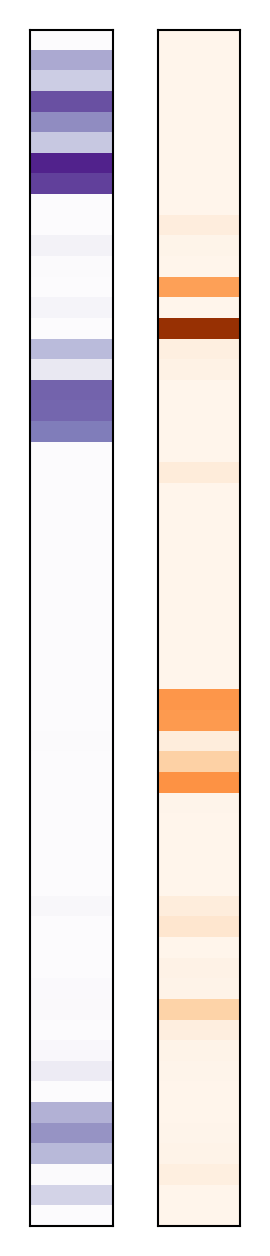

In [9]:
# fig = plt.figure(figsize=(8,8))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(1,8))

# ax = plt.subplot(1,1,1)

r_prot_img = ax1.imshow(r_prot_perc_arr[:,np.newaxis], cmap='Purples', interpolation='nearest',aspect=0.25,vmin=0,vmax=1)

ax1.set_xticks([])  # Remove x-axis ticks
ax1.set_yticks([])  # Remove y-axis ticks

t_rne_syn_img = ax2.imshow(trna_perc_arr[:,np.newaxis], cmap='Oranges', interpolation='nearest',aspect=0.25,vmin=0,vmax=1)

ax2.set_xticks([])  # Remove x-axis ticks
ax2.set_yticks([])  # Remove y-axis ticks

# Adjust spacing between subplots to remove the separation
plt.subplots_adjust(wspace=0, hspace=0)

plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/S9/Prot_Dist.png",dpi=500,transparent=True,bbox_inches="tight")

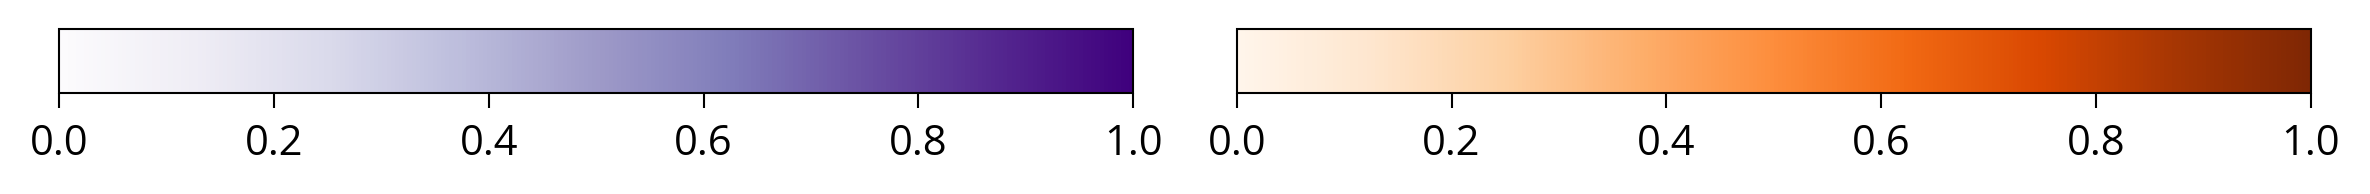

In [10]:
# Separate figure for displaying the colormaps
fig2, (cb_ax1, cb_ax2) = plt.subplots(1, 2, figsize=(8, 0.75))

# Colormap for "Purples"
cbar1 = fig2.colorbar(r_prot_img, cax=cb_ax1, orientation='horizontal')
cb_ax1.set_title("")

# Colormap for "Oranges"
cbar2 = fig2.colorbar(t_rne_syn_img, cax=cb_ax2, orientation='horizontal')
cb_ax2.set_title("")

plt.tight_layout()
plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/S9/Prot_Dist_cmap.png", dpi=500, bbox_inches="tight")
plt.show()

## Figure S9B

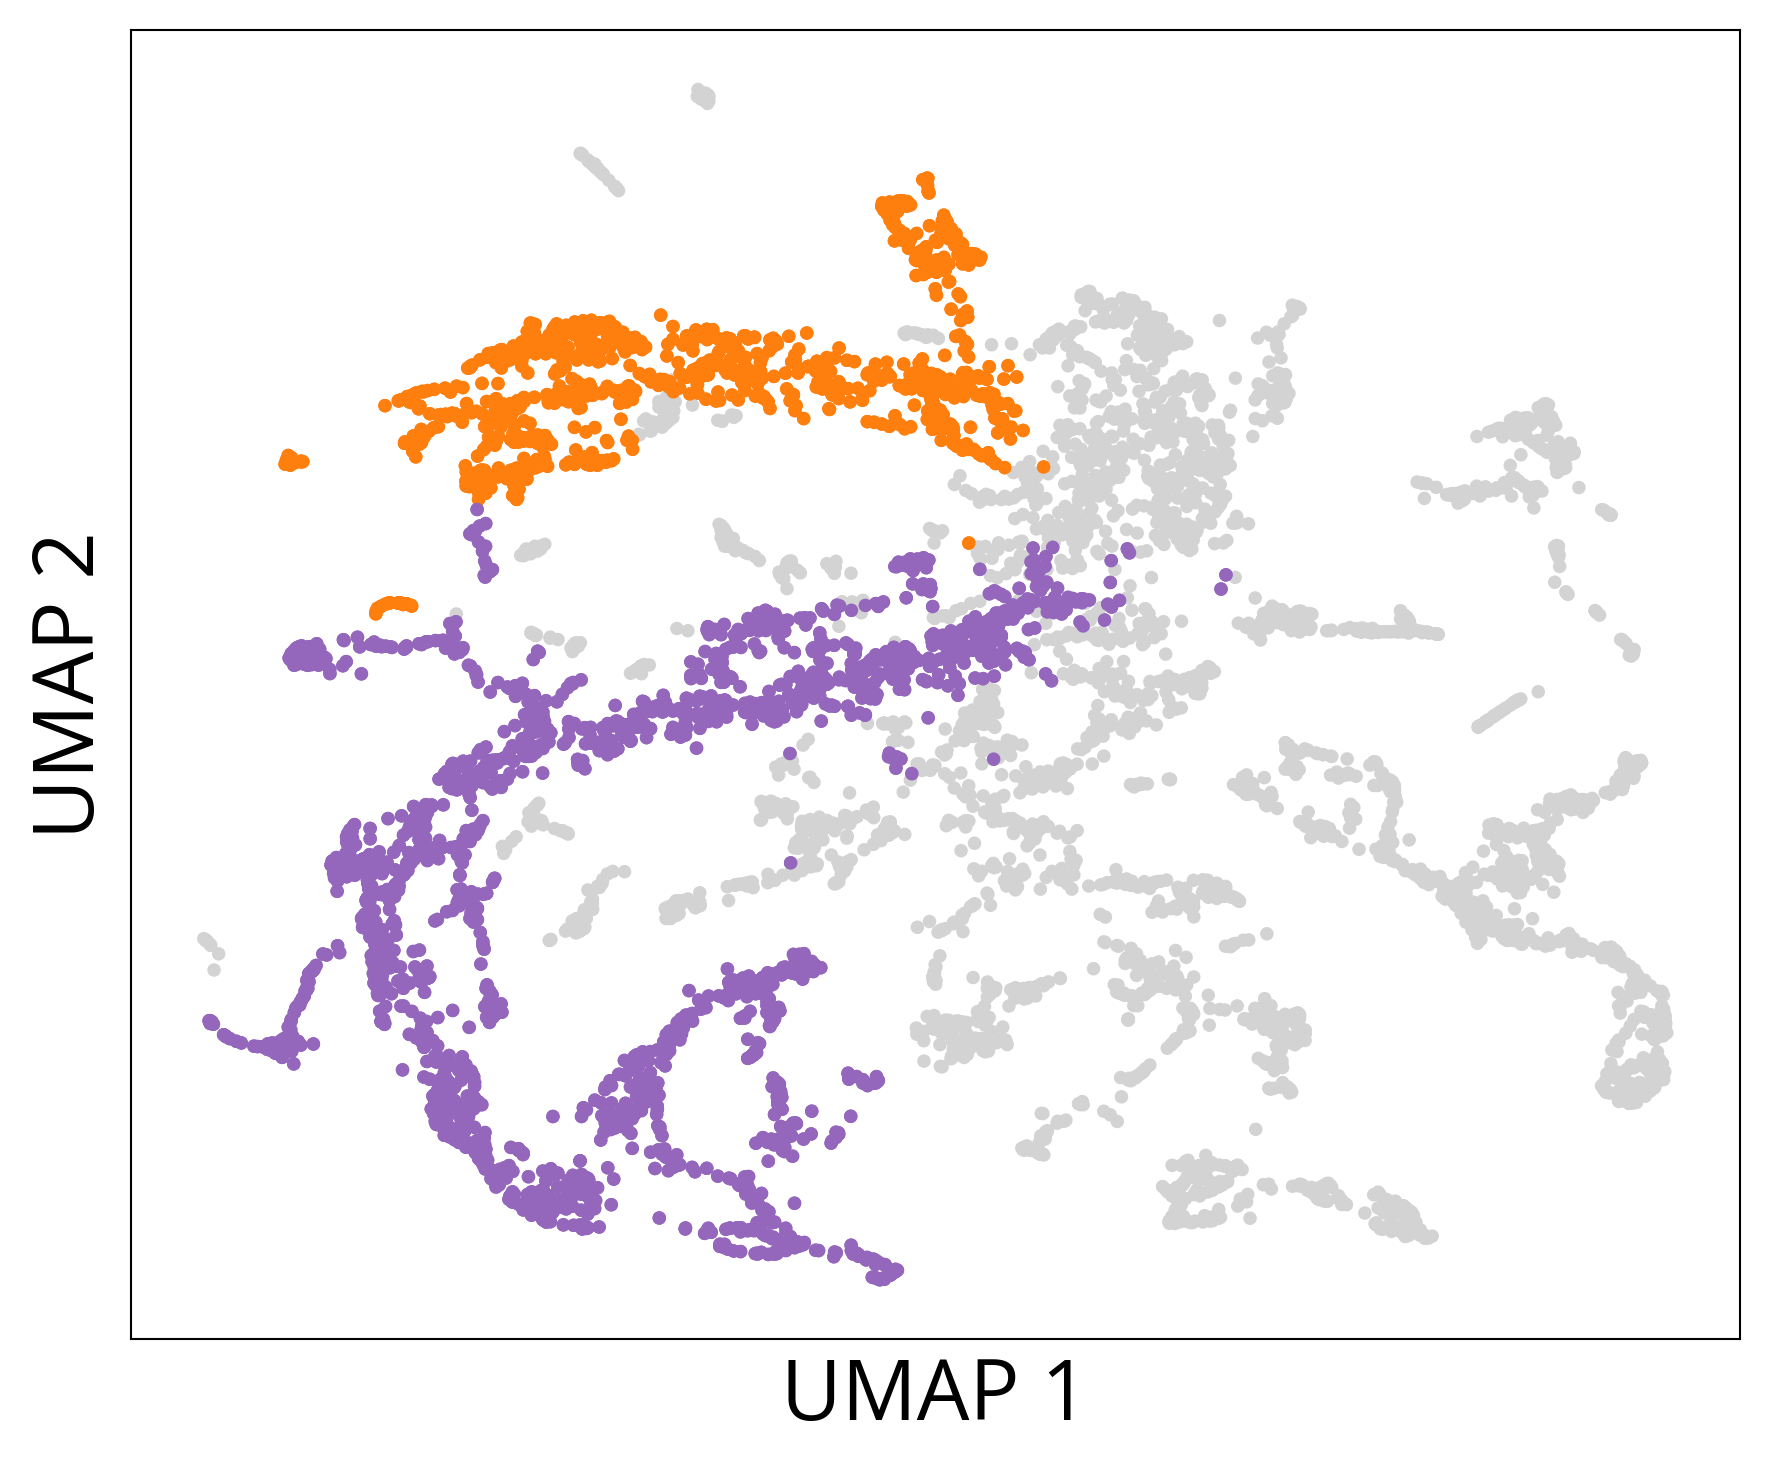

In [11]:
## indicated in the figure, hand annotated
r_prot_groups_index = [1,2,3,4,5,6,7,15,16,17,18,19,52,53,54]
trna_groups_index = [12,14,32,33,34,35,36]

fig = plt.figure(figsize=(6,5))
r_prot_clusters = r_prot_perc_series.iloc[r_prot_groups_index].index.tolist()
# r_prot_clusters = r_prot_perc_series[r_prot_perc_series>0.15].index.tolist()
trna_clusters = trna_perc_series.iloc[trna_groups_index].index.tolist()
# trna_clusters = trna_perc_series[trna_perc_series>0.15].index.tolist()

ribosome_cluster_dict = {"R Protein Clusters":r_prot_clusters,"tRNA Syn Clusters":trna_clusters}
ribosome_cluster_inv_dict = {val:key for key,val_list in ribosome_cluster_dict.items() for val in val_list}

ribosome_highlight_map = {"None":"lightgrey", "R Protein Clusters":"tab:purple", "tRNA Syn Clusters":"tab:orange"}

anndata_df.obs["Highlight Ribosome Clusters"] = anndata_df.obs["L3"].apply(lambda x: ribosome_cluster_inv_dict[x] if x in ribosome_cluster_inv_dict.keys() else "None")
# fig = plt.figure(figsize=(18,14))
ax = plt.subplot(1,1,1)

ax.scatter(anndata_df.obs["X Coord"],anndata_df.obs["Y Coord"],\
            c=anndata_df.obs["Highlight Ribosome Clusters"].apply(lambda x: ribosome_highlight_map[x]),\
            s=5,zorder=1)
ax.scatter(anndata_df.obs[anndata_df.obs["Highlight Ribosome Clusters"].isin(["R Protein Clusters","tRNA Syn Clusters"])]["X Coord"],anndata_df.obs[anndata_df.obs["Highlight Ribosome Clusters"].isin(["R Protein Clusters","tRNA Syn Clusters"])]["Y Coord"],\
            c=anndata_df.obs[anndata_df.obs["Highlight Ribosome Clusters"].isin(["R Protein Clusters","tRNA Syn Clusters"])]["Highlight Ribosome Clusters"].apply(lambda x: ribosome_highlight_map[x]),\
            s=5,zorder=1)
# ax.set_title(gene_titles[i], fontsize=16)
ax.set_ylabel("UMAP 2", fontsize=20)
ax.set_xlabel("UMAP 1", fontsize=20)
ax.set_xticks([])
ax.set_yticks([])
plt.tight_layout()
plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/S9/Ribosome_Clusters.png",dpi=500,transparent=True,bbox_inches="tight")

#### Computing Percent of R-protein KDs

In [12]:
trna_synthetases = search_go(ns2assoc, obodag, inv_gene_to_id, "GO:0006418")
all_ribosome = search_go(ns2assoc, obodag, inv_gene_to_id, "GO:0005840")
all_r_proteins = [item for item in all_ribosome if ("rpl" in item)|("rpm" in item)|("rps" in item)]
r_prot_df = anndata_df.obs[anndata_df.obs["Gene"].isin(all_r_proteins)]
trna_syn_df = anndata_df.obs[anndata_df.obs["Gene"].isin(trna_synthetases)]

Searching for tRNA aminoacylation for protein translation
Searching for ribosome


In [13]:
print(str(np.sum(r_prot_df["L3"].isin(r_prot_clusters))) + "/" + str(len(r_prot_df)))
print(np.sum(r_prot_df["L3"].isin(r_prot_clusters))/len(r_prot_df))

1205/1302
0.9254992319508448


In [14]:
print(str(np.sum(trna_syn_df["L3"].isin(trna_clusters))) + "/" + str(len(trna_syn_df)))
print(np.sum(trna_syn_df["L3"].isin(trna_clusters))/len(trna_syn_df))

340/449
0.7572383073496659


## Figure S9C

In [14]:
gene_highlight_map = {False:"lightgrey", True:"red"}

fatty_acids = search_go(ns2assoc, obodag, inv_gene_to_id, "GO:0006633")
tRNA_aminoacylation_genes = search_go(ns2assoc, obodag, inv_gene_to_id, "GO:0043039")
glycolysis_genes = search_go(ns2assoc, obodag, inv_gene_to_id, "GO:0006096")
rna_pol = search_go(ns2assoc, obodag, inv_gene_to_id, "GO:0000345")

tRNA_syn_group_1 = ["glyQ","gly","gltX","lysS","glyS","asnS"]
tRNA_syn_group_2 = list(set(tRNA_aminoacylation_genes)-set(tRNA_syn_group_1))

gene_groups = [rna_pol,fatty_acids,glycolysis_genes,tRNA_syn_group_1,tRNA_syn_group_2]
gene_titles = ["RNA Polymerase","Fatty Acid Synthesis","Glycolysis","glyQ, gltX, lysS, glyS, asnS","Other tRNA Synthetases"]

Searching for fatty acid biosynthetic process
Searching for tRNA aminoacylation
Searching for glycolytic process
Searching for cytosolic DNA-directed RNA polymerase complex


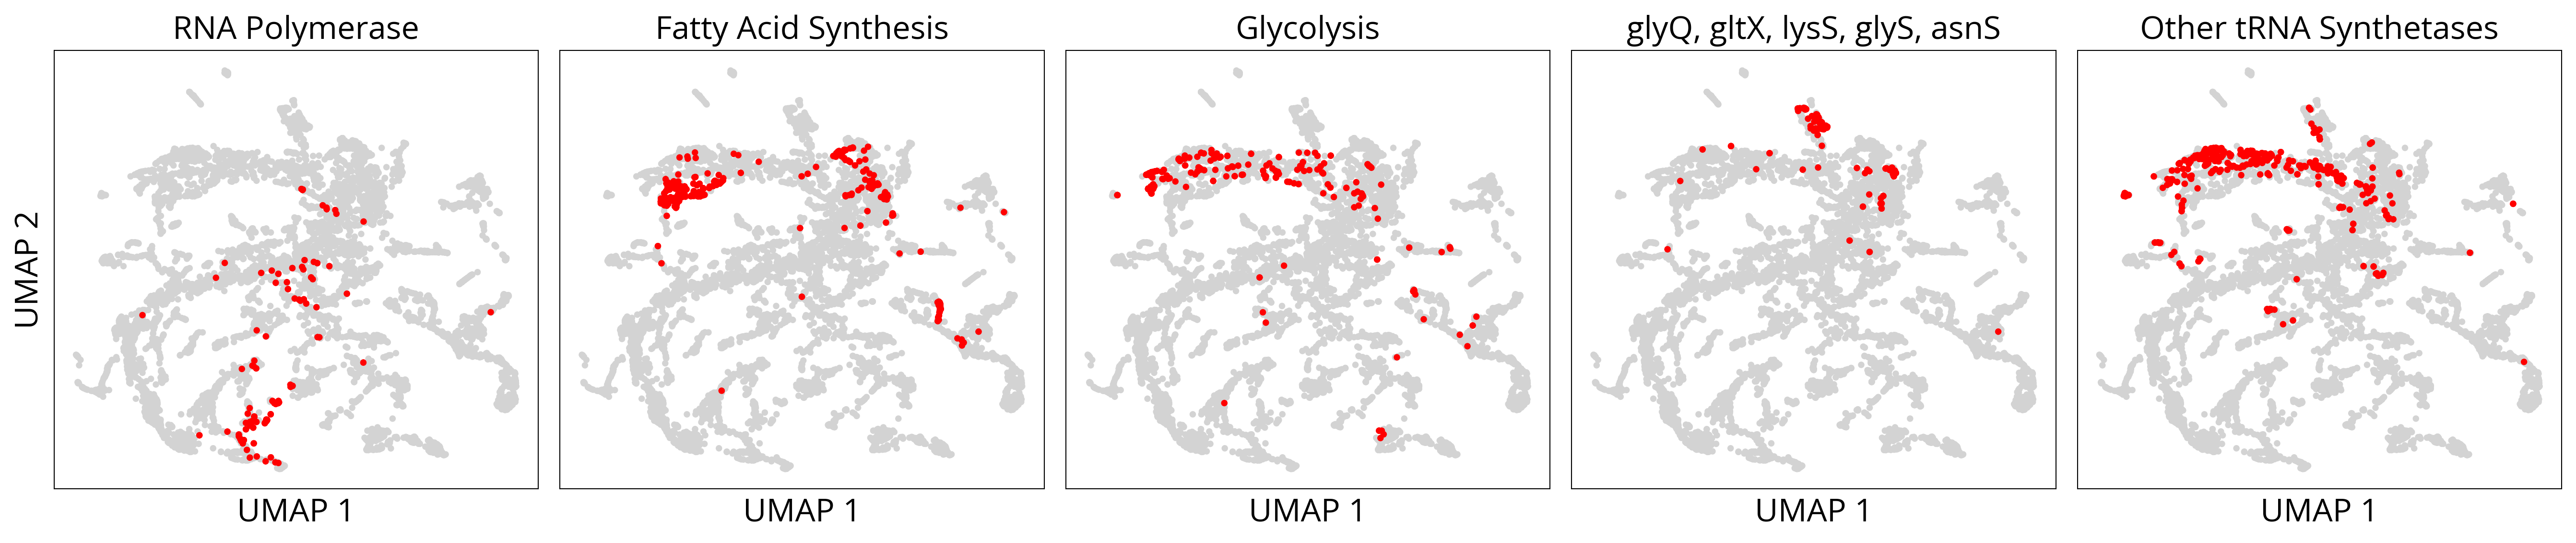

In [15]:
fig = plt.figure(figsize=(18,14))
for i in range(len(gene_groups)):
    ax = plt.subplot(4,5,i+1)
    anndata_df.obs["Highlight Gene"] = anndata_df.obs["Gene"].isin(gene_groups[i])
    
    ax.scatter(anndata_df.obs["X Coord"],anndata_df.obs["Y Coord"],\
                c=anndata_df.obs["Highlight Gene"].apply(lambda x: gene_highlight_map[x]),\
                s=5,zorder=1)
    ax.scatter(anndata_df.obs[anndata_df.obs["Highlight Gene"]]["X Coord"],anndata_df.obs[anndata_df.obs["Highlight Gene"]]["Y Coord"],\
                c=anndata_df.obs[anndata_df.obs["Highlight Gene"]]["Highlight Gene"].apply(lambda x: gene_highlight_map[x]),\
                s=5,zorder=1)
    ax.set_title(gene_titles[i], fontsize=16)
    if i == 0:
        ax.set_ylabel("UMAP 2", fontsize=16)
    else:
        ax.set_ylabel("", fontsize=16)
    ax.set_xlabel("UMAP 1", fontsize=16)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/S9/Selected_Genes_UMAP.png",dpi=500,transparent=True,bbox_inches="tight")

## Figure S9D

In [16]:
gene_highlight_map = {False:"lightgrey", True:"red"}


r_prot_groups_index = ["1","2","3","4","5","6","7","15","16","17","18","19","52","53","54"]
trna_groups_index = ["32","33","34","35","36"]

r_prot_cluster_genes,r_prot_cluster_gene_counts = np.unique(anndata_df.obs[anndata_df.obs["L3"].isin(r_prot_groups_index)]["Gene"],return_counts=True)
trna_cluster_genes,trna_cluster_gene_counts = np.unique(anndata_df.obs[anndata_df.obs["L3"].isin(trna_groups_index)]["Gene"],return_counts=True)

r_prot_unknown = list(r_prot_cluster_genes[r_prot_cluster_gene_counts>1][207:])
r_prot_unknown = list(set(r_prot_unknown)-set(["yqgE","yqgF","yrfF","ybeY","yaiP","yihA","yaaY"])) #removing genes of known function, polar effects, genes in other major clusters

trna_unknown = list(trna_cluster_genes[trna_cluster_gene_counts>1][72:])
trna_unknown = list(set(trna_unknown)-set(["ybeY","yidC","ychA"])) #removing genes of known function, polar effects, genes in other major clusters

gene_groups = [[item] for item in r_prot_unknown] + [[item] for item in trna_unknown]
gene_titles = [item for item in r_prot_unknown] + [item for item in trna_unknown]

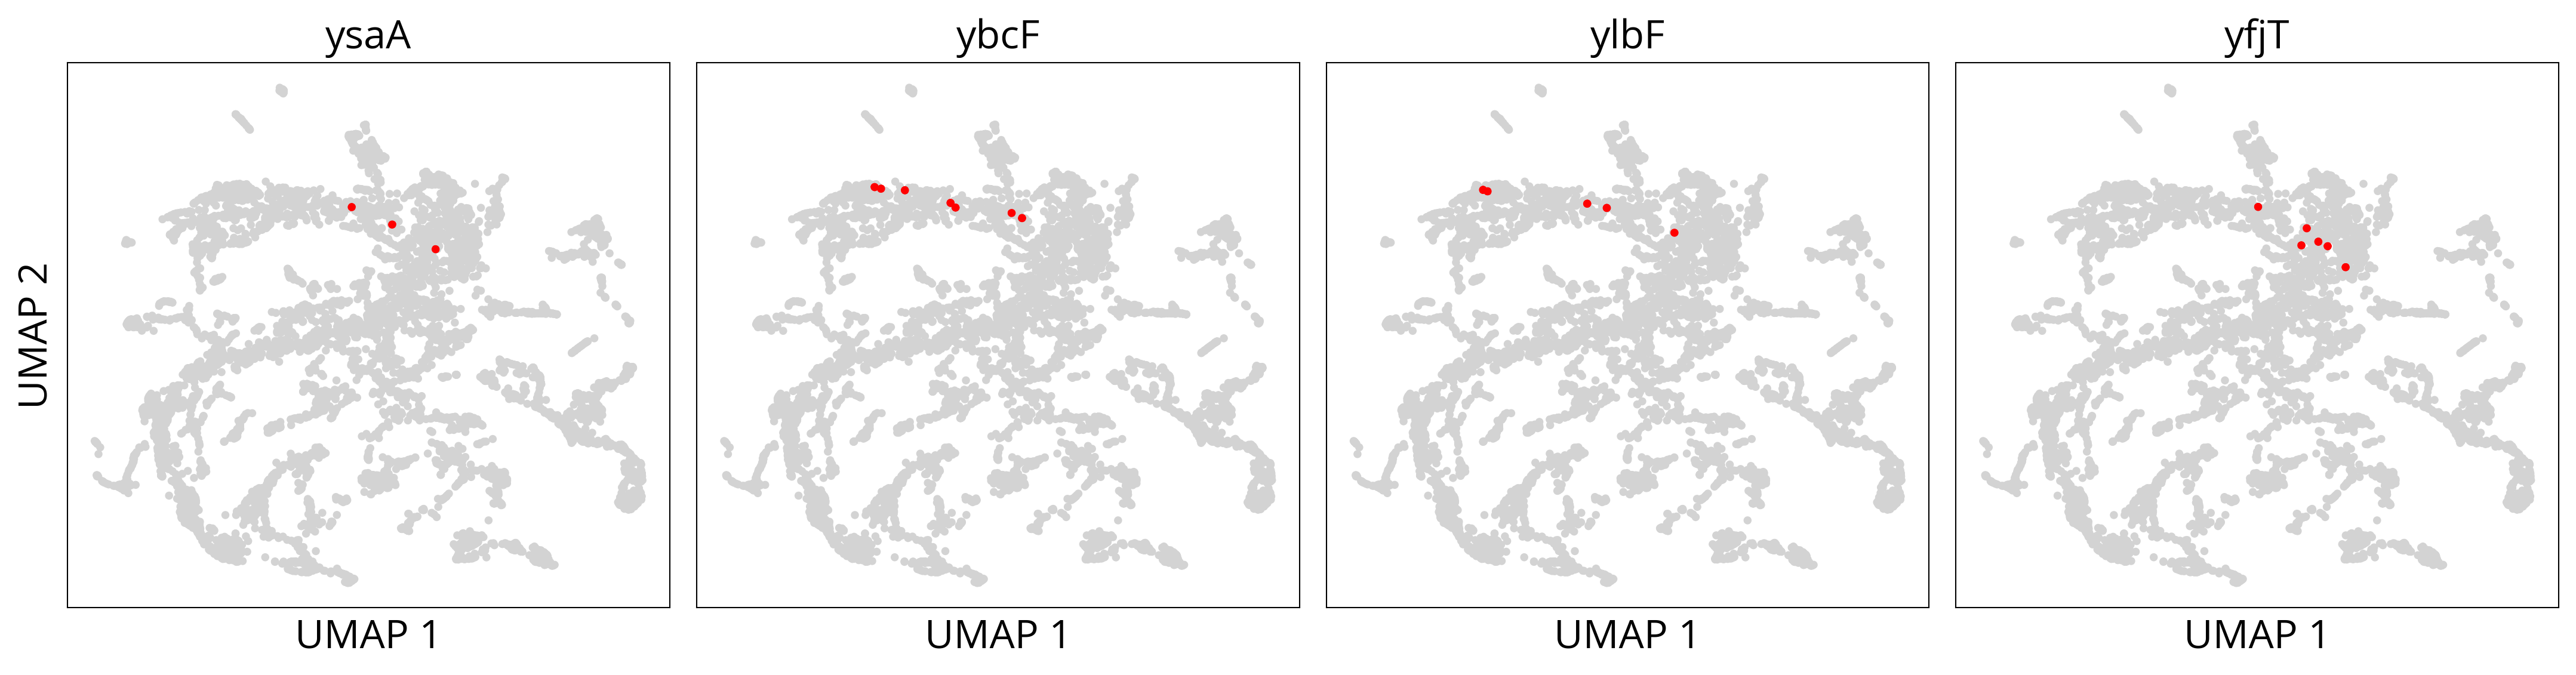

In [18]:
fig = plt.figure(figsize=(18,14))
for i in range(len(gene_groups)):
    ax = plt.subplot(4,5,i+1)
    anndata_df.obs["Highlight Gene"] = anndata_df.obs["Gene"].isin(gene_groups[i])
    
    ax.scatter(anndata_df.obs["X Coord"],anndata_df.obs["Y Coord"],\
                c=anndata_df.obs["Highlight Gene"].apply(lambda x: gene_highlight_map[x]),\
                s=5,zorder=1)
    ax.scatter(anndata_df.obs[anndata_df.obs["Highlight Gene"]]["X Coord"],anndata_df.obs[anndata_df.obs["Highlight Gene"]]["Y Coord"],\
                c=anndata_df.obs[anndata_df.obs["Highlight Gene"]]["Highlight Gene"].apply(lambda x: gene_highlight_map[x]),\
                s=5,zorder=1)
    ax.set_title(gene_titles[i], fontsize=16)
    if i == 0:
        ax.set_ylabel("UMAP 2", fontsize=16)
    else:
        ax.set_ylabel("", fontsize=16)
    ax.set_xlabel("UMAP 1", fontsize=16)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/S9/Selected_Unk_Genes_UMAP.png",dpi=500,transparent=True,bbox_inches="tight")